# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [ ]:
!pip show torch

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
    --------------------------------------- 4.7/212.5 MB 25.9 MB/s eta 0:00:09
   - -------------------------------------- 10.2/212.5 MB 25.5 MB/s eta 0:00:08
   -- ------------------------------------- 15.5/212.5 MB 25.6 MB/s eta 0:00:08
   --- ------------------------------------ 20.7/212.5 MB 25.2 MB/s eta 0:00:08
   ---- ----------------------------------- 26.0/212.5 MB 25.3 MB/s eta 0:00:08
   ----- ---------------------------------- 31.5/212.5 MB 25.3 MB/s eta 0:00:08
   ------ --------------------------------- 37.0/212.5 MB 25.5 MB/s eta 0:00:07
   ------- -------------------------------- 41.9/212.5 MB 25.4 MB/s eta 0:00:07
   -------- ------------------------------- 47.4/212.5 MB 25.4 MB/s eta 0:00:07
   --------- ------------------------------ 53.0/212.5 MB 25.4 MB/s eta 0:00:07
   ----------- ---------------------------- 58.5/212.5 MB 25.3 MB/s

In [2]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

   ---------------------------------------- 0.0/22.7 MB ? eta -:--:--
   ------- -------------------------------- 4.5/22.7 MB 26.7 MB/s eta 0:00:01
   ----------------- ---------------------- 10.0/22.7 MB 25.9 MB/s eta 0:00:01
   ------------------------- -------------- 14.7/22.7 MB 24.9 MB/s eta 0:00:01
   ----------------------------------- ---- 20.2/22.7 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------- 22.7/22.7 MB 24.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------- ----------------------- 5.2/12.9 MB 26.5 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.9 MB 25.8 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 23.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 26.0 MB/s eta 0:00:00
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cache

In [ ]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

#added by user
import torch
from torch_geometric.data import Data
from torch import 

c:\Users\veraj\anaconda3\envs\mlcourse\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\veraj\anaconda3\envs\mlcourse\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\veraj\anaconda3\envs\mlcourse\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\veraj\anaconda3\envs\mlcourse\Lib\site-packages\torch_cluster\_grid_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\veraj\anaconda3\envs\mlcourse\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue

In [6]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [7]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [8]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


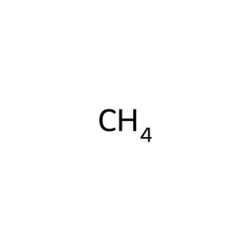

In [9]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  N  │  7   │     0.278│     0.426│     1.305
  C  │  6   │     0.078│    -0.002│     0.129
  O  │  8   │     1.055│     0.207│    -0.839
  C  │  6   │     1.396│    -0.628│    -1.874
  O  │  8   │     2.177│    -0.227│    -2.687
  C  │  6   │     0.771│    -2.003│    -1.889
  C  │  6   │    -0.713│    -1.961│    -2.280
  C  │  6   │    -1.601│    -1.320│    -1.257
  C  │  6   │    -1.242│    -0.543│    -0.232
  H  │  1   │     1.219│     0.816│     1.385
  H  │  1   │     1.337│    -2.590│    -2.614
  H  │  1   │     0.875│    -2.471│    -0.904
  H  │  1   │    -0.833│    -1.464│    -3.253
  H  │  1   │    -1.059│    -2.990│    -2.437
  H  │  1   │    -2.658│    -1.562│    -1.345
  H  │  1   │    -1.995│    -0.237│     0.487


SMILE: [NH-]C1=C[CH-]CCC(=O)O1


Formation Energy: -71.789
Formation Energy (normalized): 0.42631


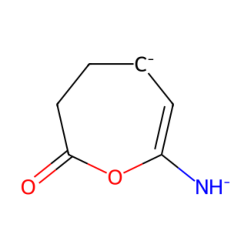

In [10]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [ ]:
import torch

def build_edges_molecule(positions, cutoff):
    """
    Given a single molecule's atom positions (Nx3 tensor or list of N 3D coords),
    returns edge_index suitable for SchNet input.
    """
    if not isinstance(positions, torch.Tensor):
        positions = torch.tensor(positions, dtype=torch.float32)

    num_atoms = positions.size(0)
    list_from = []
    list_to = []

    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                continue
            dist = torch.norm(positions[i] - positions[j])
            if dist <= cutoff:
                list_from.append(i)
                list_to.append(j)

    edge_index = torch.tensor([list_from, list_to], dtype=torch.long)
    return edge_index

def build_edges_all(pos_data, cutoff):
    """
    Build edge indices for all molecules in pos_data
    """
    edge_indices = []

    for molecule in pos_data:
        edge_index = build_edges_molecule(molecule, cutoff=cutoff)
        edge_indices.append(edge_index)

    return edge_indices


In [102]:
#edge_indices = build_edges_all(pos_data, cutoff=1.5)

# Save
#torch.save(edge_indices, "edges.pt")

# Load
edge_indices = torch.load("edges.pt")

pos_data = [torch.tensor(mol, dtype=torch.float32) for mol in pos_data]
type_data = [torch.tensor(mol, dtype=torch.long) for mol in type_data]


In [170]:
from torch.utils.data import Dataset
class MoleculeDataset(Dataset):
    def __init__(self, pos_data, type_data, edge_indices, formation_energy, indices):
        self.pos_data = pos_data
        self.type_data = type_data
        self.edge_indices = edge_indices
        self.formation_energy = formation_energy
        self.indices = indices

    def __len__(self):
        return len(self.indices)


    def __getitem__(self, idx):
        i = self.indices[idx]
        return (
            self.type_data[i], 
            self.pos_data[i],   
            self.edge_indices[i],
            self.formation_energy[i]
    )


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

batch_size = 32

class RBFExpansion(nn.Module):
    """
    Radial Basis Function Expansion is a way to transform distances
    into a set of features that can be used in neural networks.
    This uses a Gaussian RBF, like in SchNet.
    """
    def __init__(self, num_rbf=32, cutoff=1.5, gamma=10.0):
        super().__init__()
        centers = torch.linspace(0, cutoff, num_rbf) #create RBF centers, creates 32 values from 0 to cutoff
        self.register_buffer('centers', centers) #for GPU compatibility
        self.gamma = gamma

    def forward(self, distances):
        return torch.exp(-self.gamma * (distances.unsqueeze(1) - self.centers) ** 2)


class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=64, layers=2):
        super().__init__()
        net = []
        dims = [in_dim] + [hidden_dim] * (layers - 1) + [out_dim]
        for i in range(len(dims) - 1):
            net.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                net.append(nn.SiLU())
        self.model = nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)

# --- Interaction Block ---
class InteractionBlock(nn.Module):
    def __init__(self, hidden_dim, num_rbf):
        super().__init__()
        self.filter_net = MLP(num_rbf, hidden_dim)
        self.dense = nn.Linear(hidden_dim, hidden_dim)
        self.update_net = MLP(hidden_dim, hidden_dim)

    def forward(self, h, edge_index, rbf):
        row, col = edge_index
        f_ij = self.filter_net(rbf)
        m_ij = f_ij * h[col]
        agg = torch.zeros_like(h)
        agg.index_add_(0, row, m_ij)
        return h + self.update_net(self.dense(agg))

# --- SchNet as LightningModule ---
class SchNetLightning(pl.LightningModule):
    def __init__(self, num_atom_types, hidden_dim=64, num_rbf=32, num_blocks=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.rbf_layer = RBFExpansion(num_rbf)
        self.interaction_blocks = nn.ModuleList([
            InteractionBlock(hidden_dim, num_rbf) for _ in range(num_blocks)
        ])
        self.readout = MLP(hidden_dim, 1)
        self.lr = lr

    def forward(self, atom_types, positions, edge_index):
        h = self.embedding(atom_types)
        row, col = edge_index
        distances = torch.norm(positions[row] - positions[col], dim=1)
        rbf = self.rbf_layer(distances)

        for block in self.interaction_blocks:
            h = block(h, edge_index, rbf)

        atom_energies = self.readout(h).squeeze(-1)
        return atom_energies.sum()


    def training_step(self, batch, batch_idx):
        atom_types_list, positions_list, edge_indices_list, targets = batch
        pred_energies = []

        for atom_types, pos, edge_idx in zip(atom_types_list, positions_list, edge_indices_list):
            energy = self(atom_types, pos, edge_idx)
            pred_energies.append(energy)
            
        pred = torch.stack(pred_energies)
        loss = F.mse_loss(pred, targets)
        self.log("train_loss", loss, batch_size= batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        atom_types_list, positions_list, edge_indices_list, targets = batch

        pred_energies = []
        for atom_types, pos, edge_idx in zip(atom_types_list, positions_list, edge_indices_list):
            energy = self(atom_types, pos, edge_idx)
            pred_energies.append(energy)

        pred = torch.stack(pred_energies)
        loss = F.mse_loss(pred, targets)
        self.log("val_loss", loss, batch_size= batch_size)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


def custom_collate(batch):
    atom_types, positions, edge_indices, targets = zip(*batch)
    return (
        list(atom_types),
        list(positions),
        list(edge_indices),
        torch.tensor([float(t) for t in targets], dtype=torch.float32)
    )

train_idx, val_idx = train_test_split(train_idxes, test_size=0.2, random_state=0)
batch_size = 32

train_dataset = MoleculeDataset(pos_data, type_data, edge_indices, fe, train_idx)
val_dataset   = MoleculeDataset(pos_data, type_data, edge_indices, fe, val_idx)
test_dataset  = MoleculeDataset(pos_data, type_data, edge_indices, fe, test_idxes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [173]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_loss',      # metric to monitor
    patience=5,              # epochs to wait for improvement
    verbose=True,
    mode='min'               # minimize the val_loss
)

trainer = Trainer(
    max_epochs=50,
    accelerator='cpu',       # or 'gpu'
    callbacks=[early_stop_callback],
    enable_progress_bar=True # shows loss after each epoch
)
model = SchNetLightning(num_atom_types=10)
trainer.fit(model, train_loader, val_loader)




Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type         | Params | Mode 
------------------------------------------------------------
0 | embedding          | Embedding    | 640    | train
1 | rbf_layer          | RBFExpansion | 0      | train
2 | interaction_blocks | ModuleList   | 56.3 K | train
3 | readout            | MLP          | 4.2 K  | train
------------------------------------------------------------
61.1 K    Trainable params
0         Non-trainable params
61.1 K    Total params
0.244     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


c:\Users\veraj\anaconda3\envs\mlcourse\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   4%|▍         | 123/2976 [00:08<03:21, 14.14it/s, v_num=12]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [163]:
import torch
import torch.nn.functional as F

# Set model to evaluation mode
model.eval()
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        atom_types_list, positions_list, edge_indices_list, targets = batch
        preds = []
        for atom_types, pos, edge_idx in zip(atom_types_list, positions_list, edge_indices_list):
            pred = model(atom_types, pos, edge_idx)
            preds.append(pred)
        preds = torch.stack([pred if isinstance(pred, torch.Tensor) else torch.tensor(pred) for pred in preds])
        loss = F.mse_loss(preds, targets)
        test_losses.append(loss.item())

mean_test_loss = sum(test_losses) / len(test_losses)
print(f"Test MSE loss: {mean_test_loss:.4f}")

Test MSE loss: 0.1922


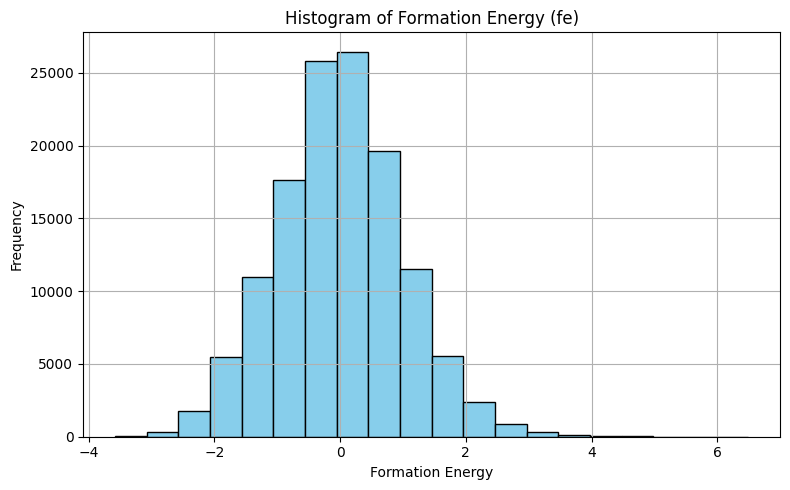

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Example: if you already have fe as a NumPy array
# fe = np.array([...])  # Your actual formation energy values

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(fe, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Formation Energy (fe)')
plt.xlabel('Formation Energy')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")